In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import norm, sem, linregress

# Get the current working directory
current_directory = os.getcwd()
# If required go to repository root
if os.path.split(current_directory)[1] != 'PAModelpy':
    # Go up one level
    parent_directory = os.path.dirname(current_directory)
    # Change the directory to the parent directory
    os.chdir(parent_directory)
    
from Scripts.ecolicore_tam_incl_transcript_info import get_transcript_data
from Scripts.tam_generation import set_up_ecolicore_tam

Loading PAModelpy modules version 0.0.3.4
Loading PAModelpy modules version 0.0.3.3


In [2]:
DATA_PATH = 'Data'
PARAM_FILE_PATH = os.path.join(DATA_PATH, 'TAModel', 'Balakrishnan-etal_2023_dogma-parameters_tableS6.xlsx')
RNA_FILE_PATH = os.path.join(DATA_PATH, 'TAModel', 'Balakrishnan-etal_2023_mrna-vs-growth_fig2a.xlsx')
ECOLI_RIBO_DIAMETER = 26 #nm for Ecoli Zhu et al 1997 DOI:9169230
DIFFUSION_COEFF_CYTOSOL_MIN = 0.4 #microm^2/s (klumpp et al 2013)
DIFFUSION_COEFF_CYTOSOL_MAX = 8 #microm^2/s (klumpp et al 2013)

In [3]:
def diffusion_limited_on_rate(diffusion_coefficient, diameter):
    return 4*np.pi*diffusion_coefficient*diameter

In [4]:
parameter_wt_df = pd.read_excel(PARAM_FILE_PATH, sheet_name = 'reference condition')
parameter_clim_df = pd.read_excel(PARAM_FILE_PATH, sheet_name = 'C-limited condition')

## Translation initiation rate distributions

In [5]:
translation_initiation_wt = parameter_wt_df['translation inititation rate αpi (1/min)']
translation_initiation_wt = [value/60 for i, value in translation_initiation_wt.items() if isinstance(value, float)]
translation_initiation_clim = parameter_clim_df['translation inititation rate αpi (1/min)']
translation_initiation_clim = [value/60 for i, value in translation_initiation_clim.items() if isinstance(value, float)]

In [6]:
print('Wildtype')
print('Lowest init rate value: ',pd.Series(translation_initiation_wt).min())
print('Median init rate value: ', pd.Series(translation_initiation_wt).median())
print('Highest init rate value: ', pd.Series(translation_initiation_wt).max())
print('Confidence interval: ', norm.interval(alpha=0.95, loc=np.mean(translation_initiation_wt), 
                                                scale=sem(translation_initiation_wt)))

print('\nC limited')
print('Lowest init rate value: ',pd.Series(translation_initiation_clim).min())
print('Median init rate value: ', pd.Series(translation_initiation_clim).median())
print('Highest init rate value: ', pd.Series(translation_initiation_clim).max())

print('Confidence interval: ', norm.interval(alpha=0.95, loc=np.mean(translation_initiation_clim), 
                                                scale=sem(translation_initiation_clim)))

Wildtype
Lowest init rate value:  0.0015067721666666666
Median init rate value:  0.23945566666666668
Highest init rate value:  358.42600000000004
Confidence interval:  (0.36377419923900933, 1.4200848181517596)

C limited
Lowest init rate value:  0.000982628
Median init rate value:  0.16632206666666666
Highest init rate value:  160.417
Confidence interval:  (0.27474858470328484, 0.6811119357398623)


In [7]:
min_diff_limited_on_rate = diffusion_limited_on_rate(DIFFUSION_COEFF_CYTOSOL_MIN, ECOLI_RIBO_DIAMETER)
max_diff_limited_on_rate = diffusion_limited_on_rate(DIFFUSION_COEFF_CYTOSOL_MAX, ECOLI_RIBO_DIAMETER)
print('calculated diffusion rates for ribosomes are between ',round(min_diff_limited_on_rate,1), ' and ', round(max_diff_limited_on_rate,1), ' microm/s')

calculated diffusion rates for ribosomes are between  130.7  and  2613.8  microm/s


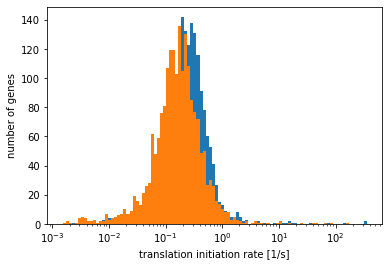

In [8]:
#plot histogram
bins =100

hist, bins = np.histogram(translation_initiation_wt, bins=bins)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(translation_initiation_wt, bins=logbins)
plt.hist(translation_initiation_clim, bins= logbins)
plt.xlabel('translation initiation rate [1/s]')
plt.ylabel('number of genes')
# plt.vlines([min_diff_limited_on_rate, max_diff_limited_on_rate], 0, 150)
plt.xscale('log')

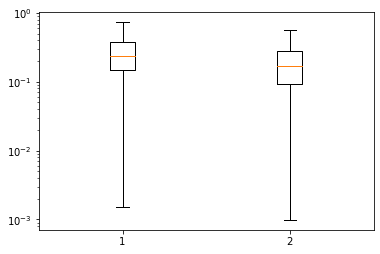

In [9]:
# plot boxplot
fig, ax = plt.subplots()

ax.boxplot([translation_initiation_wt,translation_initiation_clim], 0, '')
plt.yscale('log')

## mRNA abundance relation to growth rate

In [10]:
mrna_growth_df = pd.read_excel(RNA_FILE_PATH)

In [11]:
cell_components_basan = pd.read_excel(os.path.join(
    DATA_PATH, 'TAModel','Basan-etal_2015_STable4_cell_composition.xlsx'), 
                                      sheet_name = 'cellular_component')

#remove data from experiments which alter RNA content
cell_components_basan = cell_components_basan[~cell_components_basan['medium_addition'].str.contains('Cm', na=False)]

In [12]:
#unit conversion: cdw [microg/od] -> (*1e-6 [g/microg]) -> [gcdw/od]
#unit conversion: rna [microg/od] -> (*1e-3[mg/microg]) -> ([g/mol]) -> [mmol/od] -> ([gcdw/OD]) -> [mmol/gcdw]
#BALAKRISHNAN:
#molmass one nucleotide: 5.38 ⋅ 10−16 microg
#avg_length of mrna: 750 nt
cell_components_basan= cell_components_basan.assign(RNA_per_CDW = lambda x: x['RNA']/x['CDW'])
cell_components_basan= cell_components_basan.assign(mRNA_per_CDW = lambda x: x['RNA_per_CDW']*0.03)
cell_components_basan

,Strain,C_source,medium_addition,growth_rate,growth_rate_error,DNA,DNA_error,RNA,RNA_erroe,Protein,CDW,cell_number\n,RNA_per_CDW,mRNA_per_CDW
0,NCM3722,Glucose,RDM,1.84,0.02,11.10,0.66,153.0,8.43,329 ± 13.9,507,3.43 ± 0.16,0.301775,0.009053
1,NCM3722,Glucose,cAA,1.27,0.02,11.30,0.60,115.0,2.20,317 ± 16.3,500,7.93 ± 0.73,0.230000,0.006900
2,NCM3722,Glucose,NaN,0.98,0.01,11.90,0.67,97.9,2.37,333 ± 11.5,494,10.7 ± 0.69,0.198178,0.005945
3,NCM3722,Glycerol,NaN,0.70,0.01,14.10,0.87,83.4,3.30,355 ± 16.8,522,16.0 ± 0.98,0.159770,0.004793
4,NCM3722,Acetate,NaN,0.45,0.01,14.20,0.68,64.5,5.90,378 ± 3.39,516,17.1 ± 1.48,0.125000,0.003750
5,NCM3722,Mannose,NaN,0.42,0.01,16.50,0.49,66.1,1.40,391 ± 8.32,513,19.4 ±0.84,0.128850,0.003865
10,NQ1389,Glucose,0 ng/mL cTc,0.88,0.00,12.10,0.55,91.3,2.92,340 ± 19.4,475,9.60 ± 0.17,0.192211,0.005766
11,NQ1389,Glucose,2.5 ng/mL cTc,0.72,0.02,11.10,0.72,77.1,1.81,307 ± 8.08,458,8.07 ± 0.11,0.168341,0.005050
12,NQ1389,Glucose,5 ng/mL cTc,0.58,0.02,9.47,0.60,65.8,0.36,326 ± 13,440,6.14 ± 0.07,0.149545,0.004486
13,NQ1389,Glucose,10 ng/mL cTc,0.35,0.02,7.69,0.66,46.6,1.62,304 ± 14.2,414,3.16 ± 0.01,0.112560,0.003377


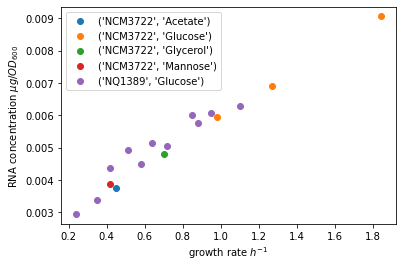

In [13]:
groups = cell_components_basan.groupby(['Strain', 'C_source'])

fig, ax = plt.subplots()
for name, group in groups:
    ax.scatter(group['growth_rate'], group['mRNA_per_CDW'], label=name)
ax.set_xlabel('growth rate $h^{-1}$')
ax.set_ylabel('RNA concentration $\mu g/OD_{600}$')
plt.legend()
plt.show()

In [14]:
mrna_vs_mu = linregress(cell_components_basan['growth_rate'], cell_components_basan['mRNA_per_CDW'])
mrna_vs_mu
#[microg/microg]

LinregressResult(slope=0.0036378316565569466, intercept=0.00245986564256536, rvalue=0.9791214624999756, pvalue=8.630258217412934e-12, stderr=0.0001950054095591478, intercept_stderr=0.0001659953123740608)

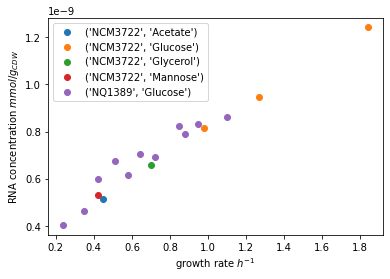

In [15]:
avg_mrna_length_ecoli = 750 #nt according to balakrishnan
mrna_nt_molmass_avg_ecoli = 324.3#Da https://bionumbers.hms.harvard.edu/bionumber.aspx?id=104886&ver=9&trm=mrna+nucleotide+composition&org=
mrna_avg_molmass = avg_mrna_length_ecoli * mrna_nt_molmass_avg_ecoli
cell_components_basan=cell_components_basan.assign(mRNA_per_CDW_mmol = lambda x: x['RNA_per_CDW']/(mrna_avg_molmass*1e3))

groups = cell_components_basan.groupby(['Strain', 'C_source'])

fig, ax = plt.subplots()
for name, group in groups:
    ax.scatter(group['growth_rate'], group['mRNA_per_CDW_mmol'], label=name)
ax.set_xlabel('growth rate $h^{-1}$')
ax.set_ylabel('RNA concentration $mmol/g_{CDW}$')
plt.legend()
plt.show()

In [16]:
mmol_mrna_vs_mu = linregress(cell_components_basan['growth_rate'], cell_components_basan['mRNA_per_CDW_mmol'])
mmol_mrna_vs_mu

LinregressResult(slope=4.985550630838314e-10, intercept=3.3711798301509036e-10, rvalue=0.9791214624999754, pvalue=8.630258217413241e-12, stderr=2.6724967904772442e-11, intercept_stderr=2.2749211960675814e-11)

## Calculating percentage of mrna allocated to active enzymes
Have to calculate the fraction of total protein which is occupied by active enzymes at a specific growth rate


In [17]:
#go to main directory for proper import statements
if os.path.split(os.getcwd())[1] == 'Scripts':
    os.chdir(os.path.split(os.getcwd())[0])
from Scripts.pam_generation import set_up_ecoli_pam


In [18]:
TOT_PROT_CONTENT = 0.54 #gp/gcdw (10.1371/journal.pone.0262450)
PROT_AE_T_UE = 0.258 #gp/gcdw (Alter et al. 2021)
f_protein_non_household = PROT_AE_T_UE/TOT_PROT_CONTENT

In [19]:
#get substrate uptake rate for growth rates using the pam. Only use simulations on glucose as those are 
#the most reliable and other carbon sources do not really change the behaviour
pamodel = set_up_ecoli_pam(unused_enzymes = True, updated_relations = True)
glc_exch_reaction = pamodel.reactions.get_by_id(pamodel.GLUCOSE_EXCHANGE_RXNID)
glc_exch_reaction.lower_bound = -1e6
glc_exch_reaction.upper_bound = 0
pamodel.objective = {glc_exch_reaction:1}
cell_components_sorted = cell_components_basan.sort_values(by = ['growth_rate'])
growth_rates_on_glucose = cell_components_sorted[cell_components_sorted['C_source'] == 'Glucose']['growth_rate']
mmol_mrna_on_glucose = cell_components_sorted[cell_components_sorted['C_source'] == 'Glucose']['mRNA_per_CDW_mmol']
g_mrna_on_glucose = cell_components_sorted[cell_components_sorted['C_source'] == 'Glucose']['mRNA_per_CDW']

substrate_uptake_rates = []

for growth_rate in growth_rates_on_glucose:
    pamodel.reactions.get_by_id(pamodel.BIOMASS_REACTION).upper_bound = growth_rate
    pamodel.reactions.get_by_id(pamodel.BIOMASS_REACTION).lower_bound = growth_rate
    pamodel.optimize()
    
    if pamodel.solver.status == 'optimal': 
        substrate_uptake_rates += [pamodel.reactions.get_by_id(pamodel.GLUCOSE_EXCHANGE_RXNID).flux]
    else:
        substrate_uptake_rates += [np.nan]
    

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2024-03-07
Read LP format model from file /tmp/tmpgee2fxtn.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Setting up the proteome allocation model iML1515

Add total condition-dependent protein constraint
	Total protein concentration: 0.258 g/gDW

Add active protein sector



/home/samiralvdb/Documents/3_Projects/7_MCA_analysis/PAModelpy/src/PAModelpy/PAModel.py:222: UserWarning: Molar mass for E332 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')


Add the following protein sector: TranslationalProteinSector

Add the following protein sector: UnusedEnzymeSector

Done with setting up the proteome allocation model iML1515



/home/samiralvdb/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/samiralvdb/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/samiralvdb/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/samiralvdb/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/samiralvdb/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/samiralvdb/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible

In [20]:
unused_enzyme_sector = pamodel.sectors.get_by_id('UnusedEnzymeSector')
translational_sector = pamodel.sectors.get_by_id('TranslationalProteinSector')
phi_ue_0 = unused_enzyme_sector.ups_0[0]
w_ue = unused_enzyme_sector.ups_mu

phi_t_0 = translational_sector.tps_0[0]
w_t = translational_sector.tps_mu[0]

In [21]:
print(phi_ue_0, w_ue, phi_t_0, w_t)

0.111925 -0.130145348837209 0.0393477666129722 0.0037020557868355304


In [24]:
mrna_per_sector_df = pd.DataFrame({'growth_rate': growth_rates_on_glucose, 
                                   'mRNA_per_CDW_mmol': mmol_mrna_on_glucose,
                                   'mRNA_per_CDW_g': g_mrna_on_glucose,
                                  'substrate_uptake_rate': [abs(rate) for rate in substrate_uptake_rates]})
mrna_per_sector_df = mrna_per_sector_df.assign(protein_ue = lambda x: phi_ue_0+w_ue*x['growth_rate'],
                                              protein_t = lambda x: phi_t_0 + w_t*x['substrate_uptake_rate'],
                                              protein_ae = lambda x: PROT_AE_T_UE - x['protein_t'] - x['protein_ue'])

In [25]:
mrna_per_sector_df = mrna_per_sector_df.assign(fraction_ue = lambda x: x['protein_ue']/TOT_PROT_CONTENT,
                                              fraction_t = lambda x: x['protein_t']/TOT_PROT_CONTENT,
                                              fraction_ae = lambda x: x['protein_ae']/TOT_PROT_CONTENT)
mrna_per_sector_df = mrna_per_sector_df.assign(mrna_ue = lambda x: x.fraction_ue*x.mRNA_per_CDW_mmol,
                                              mrna_t = lambda x: x.fraction_t*x.mRNA_per_CDW_mmol,
                                              mrna_ae = lambda x: x.fraction_ae*x.mRNA_per_CDW_mmol,
                                              mrna_ae_g = lambda x: x.fraction_ae*x.mRNA_per_CDW_g)

In [26]:
mrna_per_sector_df = mrna_per_sector_df.dropna()
mrna_per_sector_df

,growth_rate,mRNA_per_CDW_mmol,mRNA_per_CDW_g,substrate_uptake_rate,protein_ue,protein_t,protein_ae,fraction_ue,fraction_t,fraction_ae,mrna_ue,mrna_t,mrna_ae,mrna_ae_g
14,0.24,4.038188e-10,0.002947,2.968601,0.080690,0.050338,0.126972,0.149426,0.093218,0.235134,6.034109e-11,3.764316e-11,9.495141e-11,0.000693
13,0.35,4.627830e-10,0.003377,4.228137,0.066374,0.055001,0.136625,0.122915,0.101853,0.253010,5.688299e-11,4.713579e-11,1.170886e-10,0.000854
20,0.42,6.001197e-10,0.004379,5.036557,0.057264,0.057993,0.142743,0.106044,0.107395,0.264338,6.363931e-11,6.444995e-11,1.586346e-10,0.001158
19,0.51,6.754475e-10,0.004929,6.076103,0.045551,0.061842,0.150607,0.084353,0.114522,0.278902,5.697634e-11,7.735354e-11,1.883839e-10,0.001375
12,0.58,6.148441e-10,0.004486,6.888753,0.036441,0.064850,0.156709,0.067483,0.120093,0.290202,4.149138e-11,7.383858e-11,1.784289e-10,0.001302
18,0.64,7.055842e-10,0.005148,7.590956,0.028632,0.067450,0.161918,0.053022,0.124907,0.299848,3.741161e-11,8.813258e-11,2.115683e-10,0.001544
11,0.72,6.921189e-10,0.005050,8.528990,0.018220,0.070923,0.168857,0.033741,0.131338,0.312698,2.335305e-11,9.090157e-11,2.164244e-10,0.001579


In [27]:
mmol_mrna_ae_vs_mu = linregress(mrna_per_sector_df['growth_rate'], mrna_per_sector_df['mrna_ae'])
mmol_mrna_ae_vs_mu

LinregressResult(slope=2.6415151053080683e-10, intercept=3.5930841561397775e-11, rvalue=0.9660739670313448, pvalue=0.00039980420101613166, stderr=3.158087679241018e-11, intercept_stderr=1.6370787118943977e-11)

In [28]:
g_mrna_ae_vs_mu = linregress(mrna_per_sector_df['growth_rate'], mrna_per_sector_df['mrna_ae_g'])
g_mrna_ae_vs_mu

LinregressResult(slope=0.0019274475344656643, intercept=0.00026217836816312917, rvalue=0.9660739670313447, pvalue=0.0003998042010161341, stderr=0.00023043776273501935, intercept_stderr=0.00011945354091015464)

In [29]:
mrna_ae_fitted = [mmol_mrna_ae_vs_mu.intercept + mmol_mrna_ae_vs_mu.slope*mu for mu in mrna_per_sector_df.growth_rate]
mrna_ae_error_min = [mmol_mrna_ae_vs_mu.intercept-mmol_mrna_ae_vs_mu.intercept_stderr + \
                     mmol_mrna_ae_vs_mu.slope*mu-mu*mmol_mrna_ae_vs_mu.stderr for mu in mrna_per_sector_df.growth_rate]
mrna_ae_error_max = [mmol_mrna_ae_vs_mu.intercept+mmol_mrna_ae_vs_mu.intercept_stderr + \
                     mmol_mrna_ae_vs_mu.slope*mu+mu*mmol_mrna_ae_vs_mu.stderr for mu in mrna_per_sector_df.growth_rate]
print(mrna_ae_fitted)

[9.932720408879141e-11, 1.2838387024718018e-10, 1.4687447598433664e-10, 1.7064811193210925e-10, 1.8913871766926572e-10, 2.0498780830111415e-10, 2.261199291435787e-10]


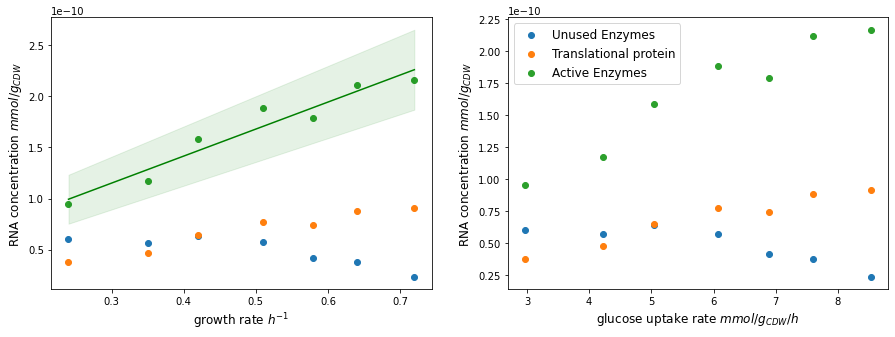

In [30]:
width = 15
height = 5
fontsize = 12

fig, axs = plt.subplots(1,2)
axs[0].scatter(mrna_per_sector_df['growth_rate'], mrna_per_sector_df['mrna_ue'], label='Unused Enzymes')
axs[0].scatter(mrna_per_sector_df['growth_rate'], mrna_per_sector_df['mrna_t'], label='Translational protein')
axs[0].scatter(mrna_per_sector_df['growth_rate'], mrna_per_sector_df['mrna_ae'], label='Active Enzymes')
axs[0].plot(mrna_per_sector_df['growth_rate'], mrna_ae_fitted, label = 'Active Enzymes Fit', color = 'green')
axs[0].fill_between(mrna_per_sector_df['growth_rate'], mrna_ae_error_min,mrna_ae_error_max,
                   alpha = 0.1, color ='green')

axs[0].set_xlabel('growth rate $h^{-1}$', fontsize = fontsize)
axs[0].set_ylabel('RNA concentration $mmol/g_{CDW}$', fontsize = fontsize)


axs[1].scatter(mrna_per_sector_df['substrate_uptake_rate'], mrna_per_sector_df['mrna_ue'], label='Unused Enzymes')
axs[1].scatter(mrna_per_sector_df['substrate_uptake_rate'], mrna_per_sector_df['mrna_t'], label='Translational protein')
axs[1].scatter(mrna_per_sector_df['substrate_uptake_rate'], mrna_per_sector_df['mrna_ae'], label='Active Enzymes')

axs[1].set_xlabel('glucose uptake rate $mmol/g_{CDW}/h$', fontsize = fontsize)
axs[1].set_ylabel('RNA concentration $mmol/g_{CDW}$', fontsize = fontsize)

fig.set_figwidth(width)
fig.set_figheight(height)
plt.legend(fontsize = fontsize)
plt.show()

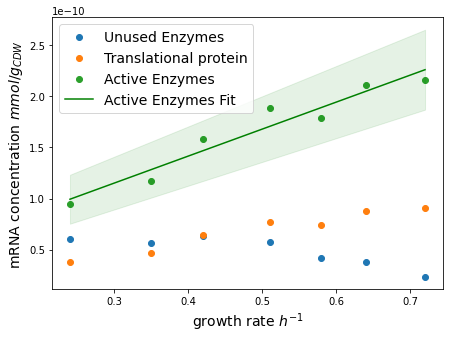

In [31]:
width = 7
height = 5
fontsize = 14

fig, ax = plt.subplots()
ax.scatter(mrna_per_sector_df['growth_rate'], mrna_per_sector_df['mrna_ue'], label='Unused Enzymes')
ax.scatter(mrna_per_sector_df['growth_rate'], mrna_per_sector_df['mrna_t'], label='Translational protein')
ax.scatter(mrna_per_sector_df['growth_rate'], mrna_per_sector_df['mrna_ae'], label='Active Enzymes')
ax.plot(mrna_per_sector_df['growth_rate'], mrna_ae_fitted, label = 'Active Enzymes Fit', color = 'green')
ax.fill_between(mrna_per_sector_df['growth_rate'], mrna_ae_error_min,mrna_ae_error_max,
                   alpha = 0.1, color ='green')

ax.set_xlabel('growth rate $h^{-1}$', fontsize = fontsize)
ax.set_ylabel('mRNA concentration $mmol/g_{CDW}$', fontsize = fontsize)

fig.set_figwidth(width)
fig.set_figheight(height)
plt.legend(fontsize = fontsize)
plt.show()

## Calculate the fraction of mRNA allocated to the core metabolism
at mu = 0.72 h-1

In [32]:
transcript_data = get_transcript_data(mmol =False)
tam = set_up_ecolicore_tam()

No enzyme information found for reaction: D_LACt2
No enzyme information found for reaction: FRD7
No enzyme information found for reaction: LDH_D
Read LP format model from file /tmp/tmpl4nlo8is.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Setting up the proteome allocation model e_coli_core

Add total condition-dependent protein constraint
	Total protein concentration: 0.16995 g/gDW

Add active protein sector

Add the following protein sector: TranslationalProteinSector

Add the following protein sector: UnusedEnzymeSector

Done with setting up the proteome allocation model e_coli_core

Add the following mRNA sector:  ActivemRNASector 

1.1.1.42
-1.0*1.1.1.42 - 1.0*1.1.1.42_reverse_0ad9c + 4687500000.0*mRNA_gene_dummy mRNA_gene_dummy_1.1.1.42_max: 0 <= -1.0*1.1.1.42 - 1.0*1.1.1.42_reverse_0ad9c + 4687500000.0*mRNA_gene_dummy <= 1000000.0
-1.0*1.1.1.42 - 1.0*1.1.1.42_reverse_0ad9c + 56250.0*mRNA_gene_dummy mRNA_gene_dummy_1.1.1.42_min: -1000000.0 <= -1.0*1.1.1.42 -

E881
-1.0*E881 - 1.0*E881_reverse_dc333 + 4687500000.0*mRNA_gene_dummy mRNA_gene_dummy_E881_max: 0 <= -1.0*E881 - 1.0*E881_reverse_dc333 + 4687500000.0*mRNA_gene_dummy <= 1000000.0
-1.0*E881 - 1.0*E881_reverse_dc333 + 56250.0*mRNA_gene_dummy mRNA_gene_dummy_E881_min: -1000000.0 <= -1.0*E881 - 1.0*E881_reverse_dc333 + 56250.0*mRNA_gene_dummy <= 0
E177
-1.0*E177 - 1.0*E177_reverse_b7980 + 4687500000.0*mRNA_gene_dummy mRNA_gene_dummy_E177_max: 0 <= -1.0*E177 - 1.0*E177_reverse_b7980 + 4687500000.0*mRNA_gene_dummy <= 1000000.0
-1.0*E177 - 1.0*E177_reverse_b7980 + 56250.0*mRNA_gene_dummy mRNA_gene_dummy_E177_min: -1000000.0 <= -1.0*E177 - 1.0*E177_reverse_b7980 + 56250.0*mRNA_gene_dummy <= 0
E356
-1.0*E356 - 1.0*E356_reverse_fab31 + 4687500000.0*mRNA_gene_dummy mRNA_gene_dummy_E356_max: 0 <= -1.0*E356 - 1.0*E356_reverse_fab31 + 4687500000.0*mRNA_gene_dummy <= 1000000.0
-1.0*E356 - 1.0*E356_reverse_fab31 + 56250.0*mRNA_gene_dummy mRNA_gene_dummy_E356_min: -1000000.0 <= -1.0*E356 - 1.0*E356_r

/home/samiralvdb/Documents/3_Projects/7_MCA_analysis/PAModelpy/src/PAModelpy/PAModel.py:222: UserWarning: Molar mass for E429 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')
/home/samiralvdb/Documents/3_Projects/7_MCA_analysis/PAModelpy/src/PAModelpy/PAModel.py:262: UserWarning: FORt: Inconsistencies between the reaction reversibility and the provided kcat values
  warnings.warn(rxn_id+': Inconsistencies between the reaction reversibility and the provided kcat values')


mRNA_b0726_1.8.1.4_min: -1000000.0 <= -1.0*1.8.1.4 - 1.0*1.8.1.4_reverse_5817c + 784560.1*mRNA_b0726 <= 0
1.8.1.4
-1.0*1.8.1.4 - 1.0*1.8.1.4_reverse_5817c + 12342408333.3333*mRNA_b0727 mRNA_b0727_1.8.1.4_max: 0 <= -1.0*1.8.1.4 - 1.0*1.8.1.4_reverse_5817c + 12342408333.3333*mRNA_b0727 <= 1000000.0
-1.0*1.8.1.4 - 1.0*1.8.1.4_reverse_5817c + 148108.9*mRNA_b0727 mRNA_b0727_1.8.1.4_min: -1000000.0 <= -1.0*1.8.1.4 - 1.0*1.8.1.4_reverse_5817c + 148108.9*mRNA_b0727 <= 0
1.8.1.4
-1.0*1.8.1.4 - 1.0*1.8.1.4_reverse_5817c + 16898133333.3333*mRNA_b0116 mRNA_b0116_1.8.1.4_max: 0 <= -1.0*1.8.1.4 - 1.0*1.8.1.4_reverse_5817c + 16898133333.3333*mRNA_b0116 <= 1000000.0
-1.0*1.8.1.4 - 1.0*1.8.1.4_reverse_5817c + 202777.6*mRNA_b0116 mRNA_b0116_1.8.1.4_min: -1000000.0 <= -1.0*1.8.1.4 - 1.0*1.8.1.4_reverse_5817c + 202777.6*mRNA_b0116 <= 0
1.2.4.1
-1.0*1.2.4.1 - 1.0*1.2.4.1_reverse_b9bf0 + 16898133333.3333*mRNA_b0116 mRNA_b0116_1.2.4.1_max: 0 <= -1.0*1.2.4.1 - 1.0*1.2.4.1_reverse_b9bf0 + 16898133333.3333*mRNA

-1.0*1.6.5.11 - 1.0*1.6.5.11_reverse_4fb5b + 28244008333.3333*mRNA_b2278 mRNA_b2278_1.6.5.11_max: 0 <= -1.0*1.6.5.11 - 1.0*1.6.5.11_reverse_4fb5b + 28244008333.3333*mRNA_b2278 <= 1000000.0
-1.0*1.6.5.11 - 1.0*1.6.5.11_reverse_4fb5b + 338928.1*mRNA_b2278 mRNA_b2278_1.6.5.11_min: -1000000.0 <= -1.0*1.6.5.11 - 1.0*1.6.5.11_reverse_4fb5b + 338928.1*mRNA_b2278 <= 0
1.6.5.11
-1.0*1.6.5.11 - 1.0*1.6.5.11_reverse_4fb5b + 2448033333.33333*mRNA_b2281 mRNA_b2281_1.6.5.11_max: 0 <= -1.0*1.6.5.11 - 1.0*1.6.5.11_reverse_4fb5b + 2448033333.33333*mRNA_b2281 <= 1000000.0
-1.0*1.6.5.11 - 1.0*1.6.5.11_reverse_4fb5b + 29376.4*mRNA_b2281 mRNA_b2281_1.6.5.11_min: -1000000.0 <= -1.0*1.6.5.11 - 1.0*1.6.5.11_reverse_4fb5b + 29376.4*mRNA_b2281 <= 0
1.6.5.11
-1.0*1.6.5.11 - 1.0*1.6.5.11_reverse_4fb5b + 2083333333.33333*mRNA_b2285 mRNA_b2285_1.6.5.11_max: 0 <= -1.0*1.6.5.11 - 1.0*1.6.5.11_reverse_4fb5b + 2083333333.33333*mRNA_b2285 <= 1000000.0
-1.0*1.6.5.11 - 1.0*1.6.5.11_reverse_4fb5b + 25000.0*mRNA_b2285 mRNA_

In [33]:
mrna_fraction = 0
for gene, expression_data in transcript_data.iterrows():
    transcript_id = 'mRNA_'+gene
    if not transcript_id in tam.transcripts: continue
    transcript = tam.transcripts.get_by_id('mRNA_'+gene)
    #wildtype condition at mu = 0.72 h-1 in first column
    mrna_fraction+=expression_data[0]
mrna_fraction

0.06770383160962078

In [35]:
mrnas_0 = mrna_fraction * mmol_mrna_ae_vs_mu.intercept
mrnas_mu = mrna_fraction * mmol_mrna_ae_vs_mu.slope

print('Core model of Ecoli has the following parameters for the active mRNA fraction:')
print(f'\t - intercept: {mrnas_0} mmol/gcdw \n\t - slope: {mrnas_mu} mmol/gcdw/h')

Core model of Ecoli has the following parameters for the active mRNA fraction:
	 - intercept: 2.4326556466648386e-12 mmol/gcdw 
	 - slope: 1.7884069388404715e-11 mmol/gcdw/h


In [36]:
mrnas_0 = mrna_fraction * g_mrna_ae_vs_mu.intercept
mrnas_mu = mrna_fraction * g_mrna_ae_vs_mu.slope

print('Core model of Ecoli has the following parameters for the active mRNA fraction:')
print(f'\t - intercept: {mrnas_0} grna/gcdw \n\t - slope: {mrnas_mu} grna/gcdw/h')

Core model of Ecoli has the following parameters for the active mRNA fraction:
	 - intercept: 1.7750480089801658e-05 grna/gcdw 
	 - slope: 0.00013049558330984208 grna/gcdw/h
